In [1]:
import json
import torch
import matplotlib.pyplot as plt
from PIL import Image
from langchain import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

In [2]:
captioner = pipeline("image-to-text",model="Salesforce/blip-image-captioning-base")

/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
def image2text(image_url, captioner):
    caption = captioner(image_url)
    return caption

In [4]:
def get_data(i):
    visual_news_data = json.load(open("../../datasets/visualnews/origin/data.json"))
    visual_news_data_mapping = {ann["id"]: ann for ann in visual_news_data}

    data = json.load(open("../../news_clippings/news_clippings/data/merged_balanced/val.json"))
    annotations = data["annotations"]
    ann_true = annotations[i]

    caption = visual_news_data_mapping[ann_true["id"]]["caption"]
    image_path = visual_news_data_mapping[ann_true["image_id"]]["image_path"]
    image_path = "../../datasets/visualnews/origin/"+image_path[2:]
    image = Image.open(image_path)
    image_desc = image2text(image_url=image_path, captioner=captioner)
    print("DATA SAMPLE")
    display(image)
    print("Caption: ", caption)
    print("Generated image description: ", image_desc)
    print("Misinformation (Ground Truth): {}".format(ann_true["falsified"]))
    return caption, image_desc

In [12]:
MODEL_NAME = "meta-llama/Llama-2-13b-chat-hf"
 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
 
model1 = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
)

model2 = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
)

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.5
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15
 
text_pipeline_1 = pipeline(
    "text-generation",
    model=model1,
    tokenizer=tokenizer,
    generation_config=generation_config,
)
 
text_pipeline_2 = pipeline(
    "text-generation",
    model=model2,
    tokenizer=tokenizer,
    generation_config=generation_config,
)
llm1 = HuggingFacePipeline(pipeline=text_pipeline_1, model_kwargs={"temperature": 0})
llm2 = HuggingFacePipeline(pipeline=text_pipeline_2, model_kwargs={"temperature": 0})

/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
from langchain import PromptTemplate
 
template = """
<s>[INST] <<SYS>>
Act as a helpful AI assistant.
<</SYS>>
 
{text} [/INST]
"""
 
prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
)

In [14]:
def get_initial_prediction(llm, prompt, image_desc, caption):
    prompt_text = """You are given an image description and the corresponding caption from a news article. 
                    Decide if the image and caption go together or not. Give reasons for your answer.
                    Image description: {}\n
                    Caption: {}""".format(image_desc, caption)
    result = llm(prompt.format(text=prompt_text))
    return result
    

In [15]:
def debate(llm, prompt, agent_response):
    prompt_text = """This is the answer another AI agent generated for the same image and text description: {}\n
                 Based on this information, refine your answer further and give reasons.""".format(agent_response)
    result = llm(prompt.format(text=prompt_text))
    return result

/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


DATA SAMPLE


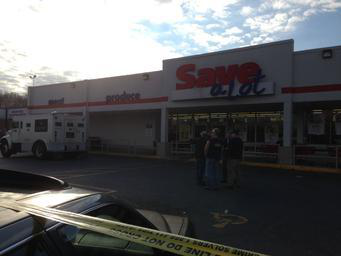

Caption:  People walk in the parking lot of an Ikea store in Brooklyn
Generated image description:  [{'generated_text': 'a police car parked in front of a store'}]
Misinformation (Ground Truth): True
data loaded!
running llm-1...
================================== RESULT FROM LLM-1 ================================== 

<s>[INST] <<SYS>>
Act as a helpful AI assistant.
<</SYS>>
 
You are given an image description and the corresponding caption from a news article. 
                    Decide if the image and caption go together or not. Give reasons for your answer.
                    Image description: [{'generated_text': 'a police car parked in front of a store'}]

                    Caption: People walk in the parking lot of an Ikea store in Brooklyn [/INST]
  Sure, I can help! Based on the image description and caption provided, it seems that the image and caption do not go together. Here's why:

The image description mentions a police car parked in front of a store, which suggests a

In [16]:
num_iters = 1
data_sample = 1
caption, image_desc = get_data(data_sample)

print("data loaded!")
print("running llm-1...")
result1 = get_initial_prediction(llm1, prompt, image_desc, caption)
print("================================== RESULT FROM LLM-1 ================================== \n{}\n ======================================================================================= ".format(result1))
print("running llm-2...")
result2 = get_initial_prediction(llm2, prompt, image_desc, caption)
print("================================== RESULT FROM LLM-2 ================================== \n{}\n ======================================================================================= ".format(result2))
print("COMMENCING DEBATE NOW...")
for i in range(num_iters):
    result1 = debate(llm1, prompt, agent_response=result2)
    print("================================== RESULT FROM LLM-1 ================================== \n{}\n ======================================================================================= ".format(result1))
    result2 = debate(llm2, prompt, agent_response=result1)
    print("================================== RESULT FROM LLM-2 ================================== \n{}\n ======================================================================================= ".format(result2))